In [1]:
# Setup and imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
from collections import Counter

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Setup complete")

Setup complete


### Step 1 : Load and Explore Dataset

In [2]:
# Load dataset
print("Loading spam dataset...")
df = pd.read_csv("Datasets/Spam_Ham_Dataset.csv")

# Clean data
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
df.columns = ['text', 'label']

# Remove empty emails
df = df[df['text'].str.len() > 10]
df = df[df['text'] != 'empty']
df = df.dropna()

print(f"Dataset loaded: {len(df):,} emails")
print(f"Spam: {sum(df['label']==1):,} ({sum(df['label']==1)/len(df)*100:.1f}%)")
print(f"Ham: {sum(df['label']==0):,} ({sum(df['label']==0)/len(df)*100:.1f}%)")

# Show basic info
df.head()

Loading spam dataset...
Dataset loaded: 5,508 emails
Spam: 1,556 (28.2%)
Ham: 3,952 (71.8%)


,text,label
0,\r\nSave up to 70% on Life Insurance.\r\nWhy S...,1
1,1) Fight The Risk of Cancer!\r\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\r\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\r\n1) Slim Dow...,1


In [3]:
# Show sample emails
print("Sample Emails:")
print("-" * 50)

print("\nSPAM Examples:")
spam_samples = df[df['label'] == 1]['text'].head(3)
for i, email in enumerate(spam_samples, 1):
    print(f"{i}. {email[:100]}...")

print("\nHAM Examples:")
ham_samples = df[df['label'] == 0]['text'].head(3)
for i, email in enumerate(ham_samples, 1):
    print(f"{i}. {email[:100]}...")

Sample Emails:
--------------------------------------------------

SPAM Examples:
1. 
Save up to 70% on Life Insurance.
Why Spend More Than You Have To?Life Quote Savings
Ensuring yo...
2. 1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk0072) Slim Down - Guaranteed to ...
3. 1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk0072) Slim Down - Guaranteed to ...

HAM Examples:
1.     Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues 
    Message-ID:...
2. Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limesto...
3. Man Threatens Explosion In Moscow Thursday August 22, 2002 1:40 PM
MOSCOW (AP) - Security officers ...


### Step 2: Text Preprocessing

In [4]:
# Text preprocessing function
def preprocess_text(text):
    """
    Clean email text for analysis.
    """
    text = str(text).lower()
    
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

# Preprocess all emails
print("Preprocessing text...")
df['clean_text'] = df['text'].apply(preprocess_text)

# Show preprocessing example
sample_email = df['text'].iloc[0]
cleaned_email = df['clean_text'].iloc[0]

print("\nPreprocessing Example:")
print(f"Original: {sample_email[:200]}...")
print(f"Cleaned:  {cleaned_email[:200]}...")

Preprocessing text...

Preprocessing Example:
Original: 
Save up to 70% on Life Insurance.
Why Spend More Than You Have To?Life Quote Savings
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying li...
Cleaned:  save life insurance spend tolife quote savings ensuring familys financial security important life quote savings makes buying life insurance simple affordable provide free access best companies lowest ...


### Step 3: Feature Extraction and Data Splitting

In [5]:
# Use subset for faster processing
sample_size = 5000
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
print(f"Using {len(df_sample):,} emails for training")

# Extract TF-IDF features
print("Extracting TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X = vectorizer.fit_transform(df_sample['clean_text'])
y = df_sample['label'].values

print(f"Feature matrix: {X.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {X_train.shape[0]:,} emails")
print(f"Testing: {X_test.shape[0]:,} emails")

Using 5,000 emails for training
Extracting TF-IDF features...
Feature matrix: (5000, 5000)
Training: 4,000 emails
Testing: 1,000 emails


### Step 4: Model Training and Comparison

In [6]:
# Train multiple models
print("Training models...")

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

model_results = {}
best_score = 0
best_model = None
best_name = None

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_results[name] = score
    print(f"   {name}: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_model = model
        best_name = name

print(f"\nBest model: {best_name} ({best_score:.4f})")

# Get predictions
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Training models...
   Naive Bayes: 0.9740
   Logistic Regression: 0.9630
   Random Forest: 0.9740

Best model: Naive Bayes (0.9740)

Test Results:
Accuracy: 0.9740

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       715
        Spam       0.95      0.95      0.95       285

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



### Step 5: Visualizations

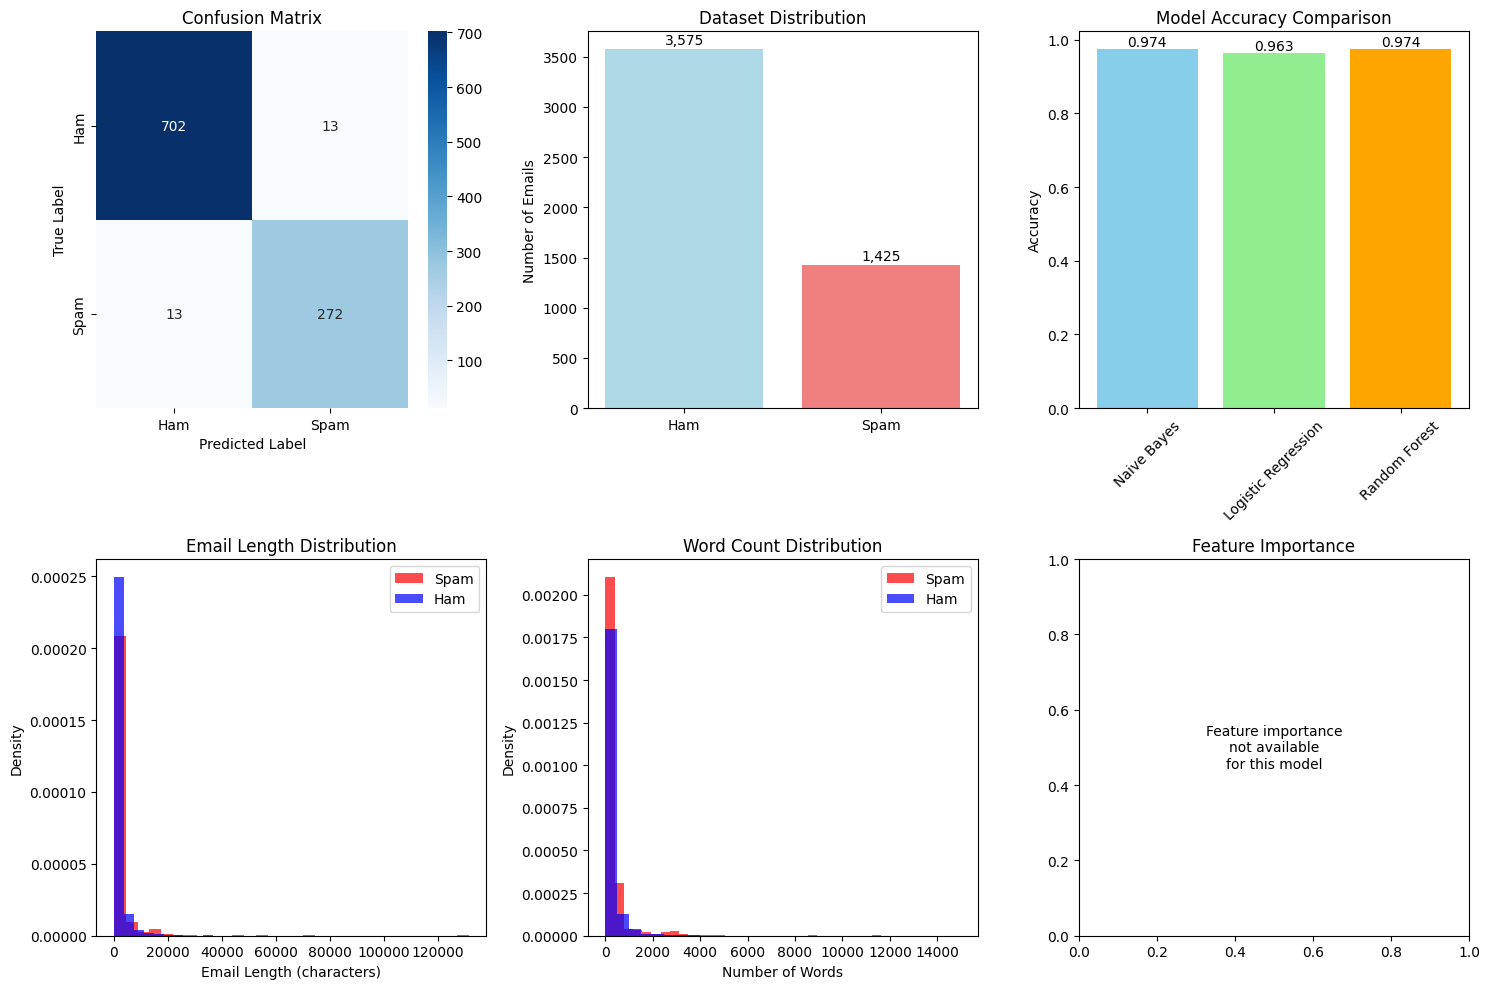

In [7]:
# Create basic plots
fig = plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Ham', 'Spam'], 
           yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 2. Dataset Distribution
ax2 = plt.subplot(2, 3, 2)
labels = ['Ham', 'Spam']
counts = [sum(df_sample['label']==0), sum(df_sample['label']==1)]
colors = ['lightblue', 'lightcoral']
bars = plt.bar(labels, counts, color=colors)
plt.title('Dataset Distribution')
plt.ylabel('Number of Emails')
for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}', ha='center')

# 3. Model Performance Comparison
ax3 = plt.subplot(2, 3, 3)
model_names = list(model_results.keys())
scores = list(model_results.values())
bars = plt.bar(model_names, scores, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center')

# 4. Email Length Distribution
ax4 = plt.subplot(2, 3, 4)
spam_lengths = [len(text) for text, label in zip(df_sample['text'], df_sample['label']) if label == 1]
ham_lengths = [len(text) for text, label in zip(df_sample['text'], df_sample['label']) if label == 0]

plt.hist(spam_lengths, bins=30, alpha=0.7, label='Spam', color='red', density=True)
plt.hist(ham_lengths, bins=30, alpha=0.7, label='Ham', color='blue', density=True)
plt.title('Email Length Distribution')
plt.xlabel('Email Length (characters)')
plt.ylabel('Density')
plt.legend()

# 5. Word Count Distribution
ax5 = plt.subplot(2, 3, 5)
spam_words = [len(text.split()) for text, label in zip(df_sample['text'], df_sample['label']) if label == 1]
ham_words = [len(text.split()) for text, label in zip(df_sample['text'], df_sample['label']) if label == 0]

plt.hist(spam_words, bins=30, alpha=0.7, label='Spam', color='red', density=True)
plt.hist(ham_words, bins=30, alpha=0.7, label='Ham', color='blue', density=True)
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()

# 6. Top Features
ax6 = plt.subplot(2, 3, 6)
if hasattr(best_model, 'coef_'):
    feature_names = vectorizer.get_feature_names_out()
    coef = best_model.coef_[0]
    
    top_spam_indices = np.argsort(coef)[-10:]
    top_spam_features = [feature_names[i] for i in top_spam_indices]
    top_spam_coef = [coef[i] for i in top_spam_indices]
    
    plt.barh(range(len(top_spam_features)), top_spam_coef, color='lightcoral')
    plt.yticks(range(len(top_spam_features)), top_spam_features)
    plt.title('Top 10 Spam Indicators')
    plt.xlabel('Feature Importance')
elif hasattr(best_model, 'feature_importances_'):
    feature_names = vectorizer.get_feature_names_out()
    importance = best_model.feature_importances_
    
    top_indices = np.argsort(importance)[-10:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = [importance[i] for i in top_indices]
    
    plt.barh(range(len(top_features)), top_importance, color='lightcoral')
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Top 10 Important Features')
    plt.xlabel('Feature Importance')
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
            ha='center', va='center', transform=ax6.transAxes)
    plt.title('Feature Importance')

plt.tight_layout()
plt.show()

### Step 6: Detailed Analysis Visualizations

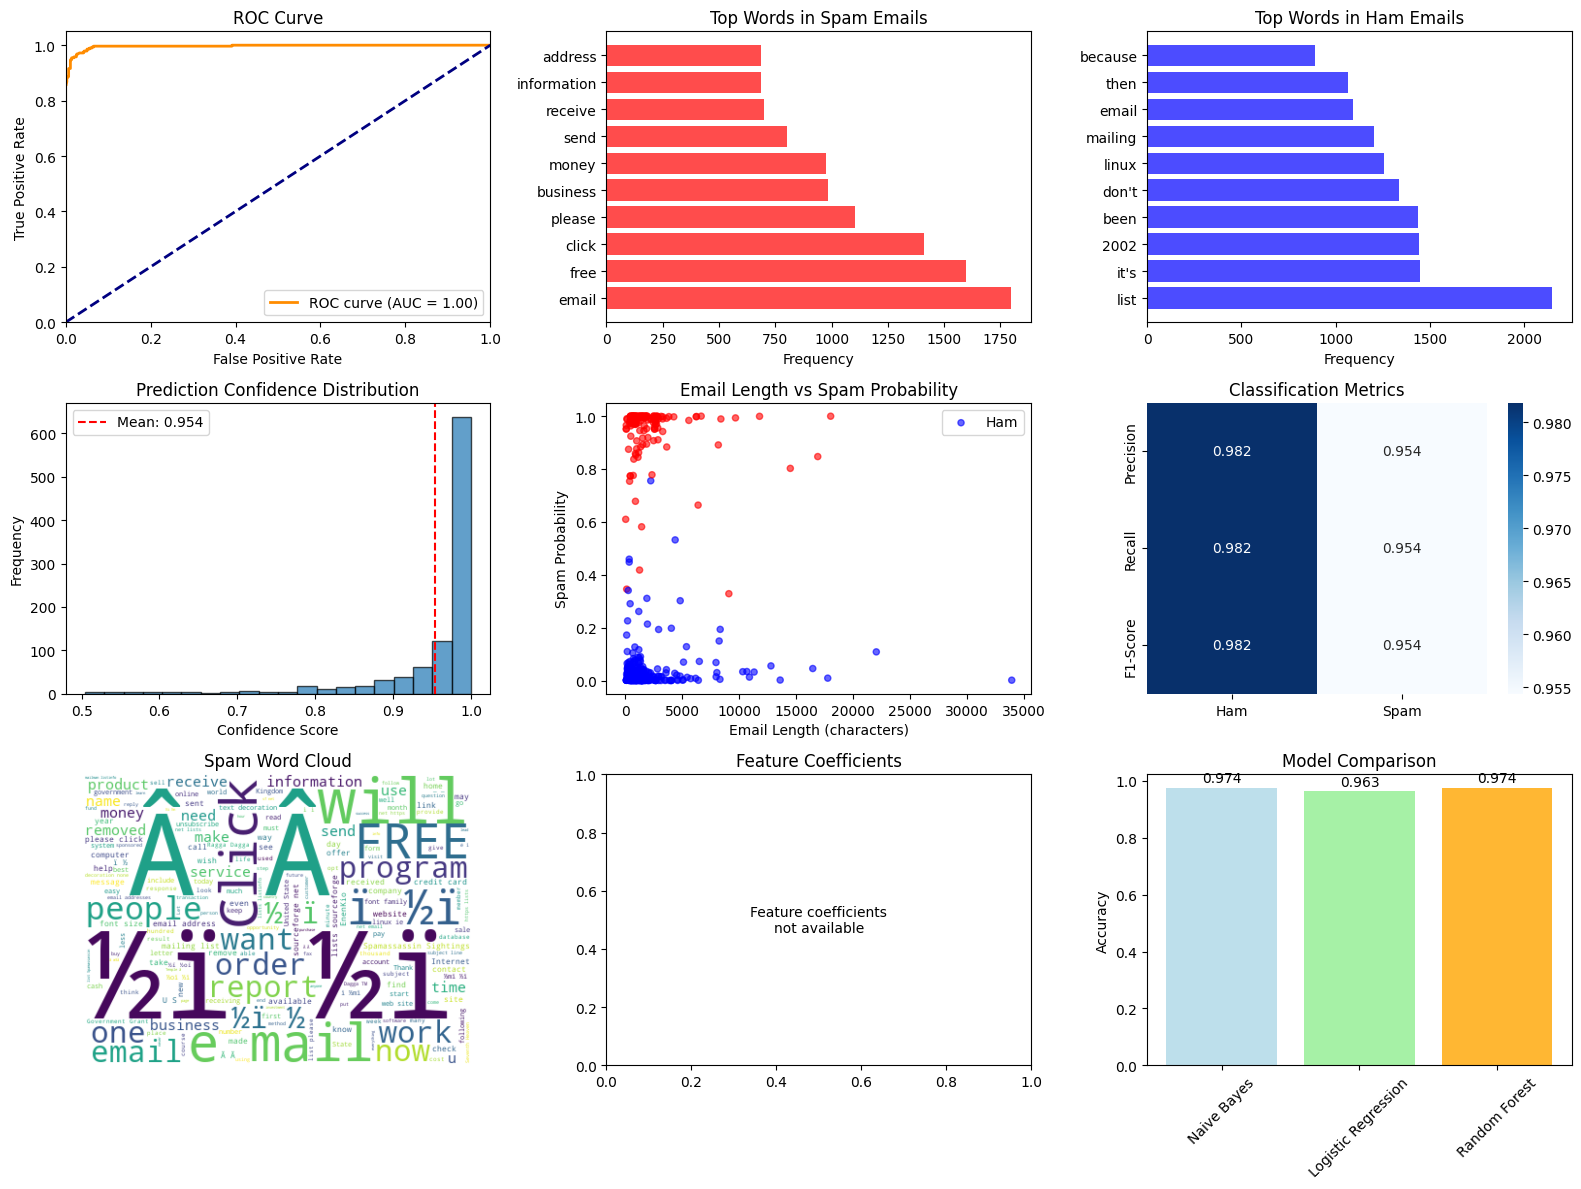

In [8]:
# Create detailed analysis plots
fig = plt.figure(figsize=(16, 12))

# 1. ROC Curve
ax1 = plt.subplot(3, 3, 1)
if hasattr(best_model, 'predict_proba'):
    from sklearn.metrics import roc_curve, auc
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
else:
    plt.text(0.5, 0.5, 'ROC curve not\navailable', ha='center', va='center')
    plt.title('ROC Curve')

# 2. Common Words in Spam
ax2 = plt.subplot(3, 3, 2)
spam_texts = ' '.join([text for text, label in zip(df_sample['text'], df_sample['label']) if label == 1])
spam_words = spam_texts.lower().split()
spam_word_freq = Counter(spam_words)

# Filter common words
common_words = ['the', 'and', 'to', 'of', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they', 'i', 'at', 'be', 'this', 'have', 'from', 'or', 'one', 'had', 'by', 'word', 'but', 'not', 'what', 'all', 'were', 'we', 'when', 'your', 'can', 'said', 'there', 'use', 'an', 'each', 'which', 'she', 'do', 'how', 'their', 'if', 'will', 'up', 'other', 'about', 'out', 'many', 'time', 'has', 'them', 'these', 'two', 'more', 'very', 'her', 'would', 'like', 'into', 'him', 'some', 'could', 'get', 'may', 'way', 'day', 'my', 'go', 'see', 'no', 'come', 'just', 'now', 'people', 'only', 'over', 'know', 'think', 'also', 'back', 'after', 'first', 'well', 'new', 'want', 'give', 'most', 'us', 'any', 'work', 'life', 'year', 'where', 'much', 'make', 'good', 'take', 'right', 'than', 'here', 'through', 'find', 'great', 'still', 'should', 'own', 'say', 'help', 'small', 'end', 'such', 'need', 'place', 'even', 'long', 'look', 'never', 'before', 'same', 'big', 'those', 'little', 'under', 'might', 'while', 'too', 'old', 'does', 'different', 'off', 'again', 'turn', 'another', 'must', 'why', 'ask', 'men', 'read', 'try', 'called', 'who', 'feel', 'being', 'made', 'young', 'did', 'come', 'its', 'open', 'run', 'talk', 'keep', 'both', 'important', 'since', 'number', 'part', 'down', 'tell', 'problem', 'hand', 'large', 'against', 'public', 'follow', 'during', 'thought', 'case', 'question', 'later', 'community', 'within', 'state', 'almost', 'include', 'continue', 'set', 'example', 'between', 'provide', 'service', 'company', 'system', 'program', 'group', 'room', 'family', 'last', 'school', 'every', 'don', 're', 've', 'll', 'm', 't', 's']

filtered_words = {word: count for word, count in spam_word_freq.items() 
                 if word not in common_words and len(word) > 3 and count > 10}

if filtered_words:
    top_spam_words = dict(Counter(filtered_words).most_common(10))
    plt.barh(range(len(top_spam_words)), list(top_spam_words.values()), color='red', alpha=0.7)
    plt.yticks(range(len(top_spam_words)), list(top_spam_words.keys()))
    plt.title('Top Words in Spam Emails')
    plt.xlabel('Frequency')
else:
    plt.text(0.5, 0.5, 'No frequent\nspam words found', ha='center', va='center')
    plt.title('Top Words in Spam Emails')

# 3. Common Words in Ham
ax3 = plt.subplot(3, 3, 3)
ham_texts = ' '.join([text for text, label in zip(df_sample['text'], df_sample['label']) if label == 0])
ham_words = ham_texts.lower().split()
ham_word_freq = Counter(ham_words)

filtered_ham_words = {word: count for word, count in ham_word_freq.items() 
                     if word not in common_words and len(word) > 3 and count > 20}

if filtered_ham_words:
    top_ham_words = dict(Counter(filtered_ham_words).most_common(10))
    plt.barh(range(len(top_ham_words)), list(top_ham_words.values()), color='blue', alpha=0.7)
    plt.yticks(range(len(top_ham_words)), list(top_ham_words.keys()))
    plt.title('Top Words in Ham Emails')
    plt.xlabel('Frequency')
else:
    plt.text(0.5, 0.5, 'No frequent\nham words found', ha='center', va='center')
    plt.title('Top Words in Ham Emails')

# 4. Prediction Confidence Distribution
ax4 = plt.subplot(3, 3, 4)
if hasattr(best_model, 'predict_proba'):
    probabilities = best_model.predict_proba(X_test)
    confidences = np.max(probabilities, axis=1)
    
    plt.hist(confidences, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(confidences), color='red', linestyle='--', 
               label=f'Mean: {np.mean(confidences):.3f}')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Confidence data\nnot available', ha='center', va='center')
    plt.title('Prediction Confidence Distribution')

# 5. Email Length vs Spam Probability
ax5 = plt.subplot(3, 3, 5)
if hasattr(best_model, 'predict_proba'):
    sample_data = df_sample.sample(n=min(500, len(df_sample)), random_state=42)
    lengths = [len(text) for text in sample_data['text']]
    texts_processed = [preprocess_text(text) for text in sample_data['text']]
    features = vectorizer.transform(texts_processed)
    spam_probs = best_model.predict_proba(features)[:, 1]
    
    colors = ['red' if label == 1 else 'blue' for label in sample_data['label']]
    plt.scatter(lengths, spam_probs, c=colors, alpha=0.6, s=20)
    plt.title('Email Length vs Spam Probability')
    plt.xlabel('Email Length (characters)')
    plt.ylabel('Spam Probability')
    plt.legend(['Ham', 'Spam'])
else:
    plt.text(0.5, 0.5, 'Probability data\nnot available', ha='center', va='center')
    plt.title('Email Length vs Spam Probability')

# 6. Classification Report Heatmap
ax6 = plt.subplot(3, 3, 6)
report = classification_report(y_test, y_pred, output_dict=True)

metrics_df = pd.DataFrame({
    'Ham': [report['0']['precision'], report['0']['recall'], report['0']['f1-score']],
    'Spam': [report['1']['precision'], report['1']['recall'], report['1']['f1-score']]
}, index=['Precision', 'Recall', 'F1-Score'])

sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues', cbar=True)
plt.title('Classification Metrics')

# 7. Word Cloud for Spam (simplified)
ax7 = plt.subplot(3, 3, 7)
try:
    from wordcloud import WordCloud
    spam_text = ' '.join([text for text, label in zip(df_sample['text'], df_sample['label']) if label == 1])
    if spam_text:
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(spam_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Spam Word Cloud')
    else:
        plt.text(0.5, 0.5, 'No spam text\navailable', ha='center', va='center')
        plt.title('Spam Word Cloud')
except ImportError:
    plt.text(0.5, 0.5, 'WordCloud not\ninstalled', ha='center', va='center')
    plt.title('Spam Word Cloud')

# 8. Feature Coefficients
ax8 = plt.subplot(3, 3, 8)
if hasattr(best_model, 'coef_'):
    feature_names = vectorizer.get_feature_names_out()
    coef = best_model.coef_[0]
    
    top_spam_indices = np.argsort(coef)[-5:]
    top_ham_indices = np.argsort(coef)[:5]
    
    features = [feature_names[i] for i in np.concatenate([top_ham_indices, top_spam_indices])]
    coefficients = [coef[i] for i in np.concatenate([top_ham_indices, top_spam_indices])]
    colors = ['blue'] * 5 + ['red'] * 5
    
    bars = plt.barh(range(len(features)), coefficients, color=colors, alpha=0.7)
    plt.yticks(range(len(features)), features)
    plt.title('Feature Coefficients (Ham vs Spam)')
    plt.xlabel('Coefficient Value')
else:
    plt.text(0.5, 0.5, 'Feature coefficients\nnot available', ha='center', va='center')
    plt.title('Feature Coefficients')

# 9. Model Comparison
ax9 = plt.subplot(3, 3, 9)
model_names = list(model_results.keys())
scores = list(model_results.values())

x_pos = np.arange(len(model_names))
bars = plt.bar(x_pos, scores, color=['lightblue', 'lightgreen', 'orange'], alpha=0.8)
plt.xticks(x_pos, model_names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison')

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Step 7: Email Prediction Function

In [9]:
def check_email(email_text):
    """
    Check if an email is spam or ham.
    """
    # Preprocess and predict
    clean_text = preprocess_text(email_text)
    features = vectorizer.transform([clean_text])
    
    prediction = best_model.predict(features)[0]
    
    if hasattr(best_model, 'predict_proba'):
        probability = best_model.predict_proba(features)[0]
        confidence = max(probability)
        spam_prob = probability[1] if len(probability) > 1 else probability[0]
    else:
        confidence = 1.0
        spam_prob = 1.0 if prediction == 1 else 0.0
    
    result = {
        'prediction': 'Spam' if prediction == 1 else 'Ham',
        'confidence': confidence,
        'spam_probability': spam_prob
    }
    
    print("Email Analysis Results:")
    print("-" * 30)
    print(f"Email text: \"{email_text[:100]}...\"")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.3f}")
    print(f"Spam probability: {result['spam_probability']:.3f}")
    
    if result['prediction'] == 'Spam':
        print("Status: WARNING - Likely SPAM")
    else:
        print("Status: Appears legitimate")
    
    return result

print("Email checking function ready!")
print("Use: check_email('your email text here')")

Email checking function ready!
Use: check_email('your email text here')


### Step 8: Test Sample Emails

In [10]:
# Test on sample emails
test_emails = [
    "FREE MONEY! Win $10000 now! Click here immediately!",
    "Meeting scheduled for tomorrow at 2 PM in conference room B",
    "URGENT: Your account will be suspended! Verify now!",
    "Your Amazon order has been shipped successfully",
    "Congratulations! You've won $1000! Click here now!",
    "Please find the quarterly report attached for your review"
]

print("Testing Sample Emails:")
print("=" * 60)

for i, email in enumerate(test_emails, 1):
    print(f"\n{i}. Testing email...")
    check_email(email)
    print("-" * 60)

Testing Sample Emails:

1. Testing email...
Email Analysis Results:
------------------------------
Email text: "FREE MONEY! Win $10000 now! Click here immediately!..."
Prediction: Spam
Confidence: 0.821
Spam probability: 0.821
Status: WARNING - Likely SPAM
------------------------------------------------------------

2. Testing email...
Email Analysis Results:
------------------------------
Email text: "Meeting scheduled for tomorrow at 2 PM in conference room B..."
Prediction: Ham
Confidence: 0.840
Spam probability: 0.160
Status: Appears legitimate
------------------------------------------------------------

3. Testing email...
Email Analysis Results:
------------------------------
Email text: "URGENT: Your account will be suspended! Verify now!..."
Prediction: Spam
Confidence: 0.645
Spam probability: 0.645
Status: WARNING - Likely SPAM
------------------------------------------------------------

4. Testing email...
Email Analysis Results:
------------------------------
Email text: 